# 解决问题：计算泰坦尼克号人员的存活率
## 数据来源：https://www.kaggle.com/c/titanic
#### PassengerId: 乘客编号
#### Survived:   （1：存活，0：死亡）
#### Pclass：     客舱等级（1：一等舱，2：二等舱，3：三等舱）
#### Name         姓名
#### Sex          性别
#### Age          年龄
#### SibSp        船上兄弟姐妹数/配偶数（同代直系亲属数量）
#### Parch        船上父母数/子女数（不同代直系亲属数）
#### Ticket       船票编号
#### Fare         船票价格
#### Cabin        客舱号码
#### Embarked     登船港口（S：出发地-Southampton，C：途径地点-Cherbourg，Q：途径地点-QueenS）

In [1]:
# 导入数据处理包
import numpy as np
import pandas as pd
# 忽略警告提醒
import warnings
warnings.filterwarnings('ignore')
# 导入数据
Path=r'C:/Users/陈建梅/Desktop/3.泰坦尼克号/'
train=pd.read_csv(Path+'train.csv')
test=pd.read_csv(Path+'test.csv')
print("训练数据集：",train.shape,", 测试数据集：",test.shape)
row_test=test.shape[0]
row_train=train.shape[0]

训练数据集： (891, 12) , 测试数据集： (418, 11)


In [2]:
# 将训练数据和测试数据和并到一起,方便对数据进行清洗
full=train.append(test,ignore_index="true")
full.shape      #  先行后列
full.describe() # 只能查看数值类的，统计学描述数据:count mean std min 四分点 中位数 max
# Fare--最低是0，需要清洗；count--可以看到缺失值；
full.head()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# 数据预处理：数据整容，如处理缺失数据；特征工程
1. 选择子集     # 选择一部分数据进行分析
2. 列名重命名
3. 缺失数据处理 # 空值
4. 数据类型转换 # 字符串转数值
5. 数据排序     #  发现更多有价值信息
6. 异常值处理   # 不符合常理，如船票价格为0

In [3]:
from collections import Counter  
# 处理缺失值，平均数填充
full['Age']=full['Age'].fillna(full['Age'].mean())
full['Fare']=full['Fare'].fillna(full['Fare'].mean())
# 处理缺失值，填充为最频繁出现的值
# Counter(full['Embarked']).most_common(1)[0][0] : most_common返回元组的列表，取第一个列表值=元组，取第一个元组值
# full['Embarked'].value_counts().index[0]
full['Embarked']=full['Embarked'].fillna(Counter(full['Embarked']).most_common(1)[0][0])
# 无法填充缺失值，进行标识为未知
full['Cabin']=full['Cabin'].fillna('U')
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


#### 特征工程：最大限度地从原始数据中提取特征，已供机器学习算法和模型使用
#### Feature Engineering is manuallly designing what the input x's should be.
#### 特征工程：特征提取+特征选择和特征降维
#### 特征提取：1. 数值类型：直接使用；2. 时间序列：转成单独的年月日；3. 分类数据：用数值代表类别one-hot编码
#### one-hot编码：（one-hot为人为虚置的变量，又称为虚拟变量和哑变量dummy variables）：
#### Embarked(S,C,Q)-->生成三个特征Embarked_S,Embarked_C,Embarked_Q(100,010,001)

In [4]:
# 修改非数值类型
# 1. 两个类别：字典映射处理--性别：male：1；female：0；
sex_mapDict={'male':1,'female':0}
full['Sex']=full['Sex'].map(sex_mapDict)
# 2. 多个类别：one-hot编码
dummiesEmbarked = pd.get_dummies( full['Embarked'] , prefix='Embarked' )
dummiesPclass = pd.get_dummies( full['Pclass'] , prefix='Pclass' )

# pd.concat([full,dummiesEmbarked],axis=1)
full=full.join([dummiesEmbarked,dummiesPclass])
# 因为drop(name,axis=1)里面指定了name是哪一列，比如指定的是A这一列，axis=1表示按行操作

full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,U,S,0,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,0,1,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,0,1,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,U,S,0,0,1,0,0,1


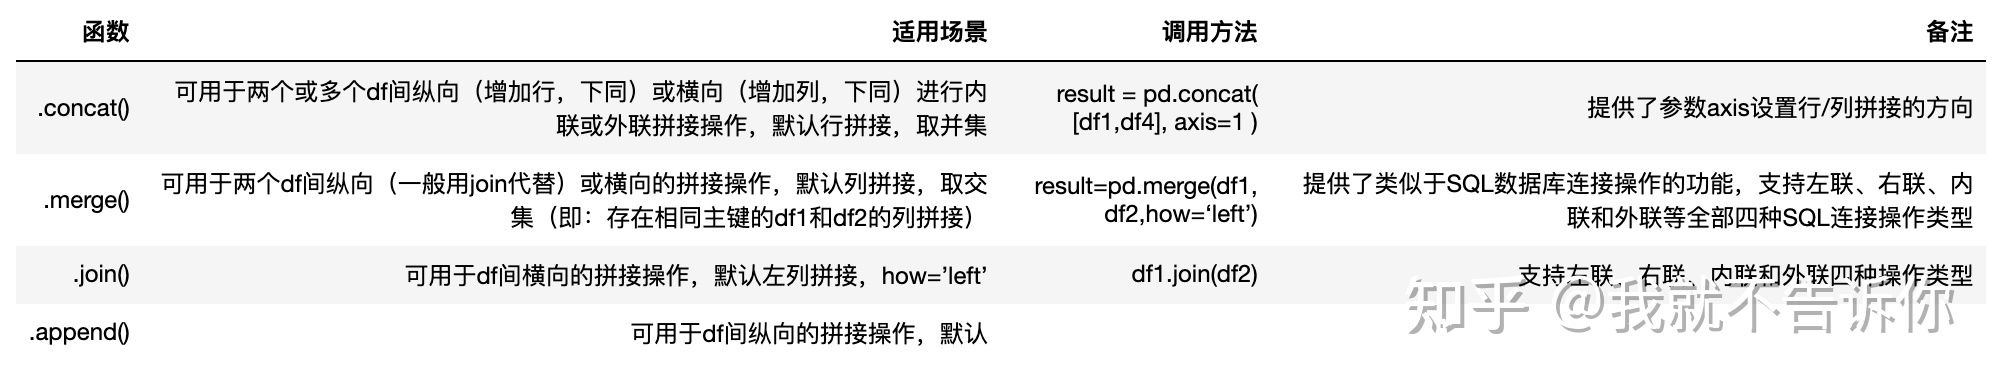

### 在特征中提取新的特征
#### 注意到在乘客名字（Name）中，有一个非常显著的特点：
#### 乘客头衔每个名字当中都包含了具体的称谓或者说是头衔，将这部分信息提取出来后可以作为非常有用一个新变量，可以帮助我们进行预测。
#### 姓名：名，头衔.姓

In [5]:
# 函数：获取头衔 'Braund, Mr. Owen Harris'
#姓名中头衔字符串与定义头衔类别的映射关系
title_mapDict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

full['Title']=full['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip()).map(title_mapDict)
full['Cabin']=full['Cabin'].map(lambda cabin:list(cabin)[0].upper())
dummiesTitle=pd.get_dummies( full['Title'] , prefix='Title' )
dummiesCabin=pd.get_dummies( full['Cabin'] , prefix='Cabin' )
full=full.join([dummiesTitle,dummiesCabin])
full=full.drop(['Title','Name','Cabin','Embarked','Pclass'],axis=1)

In [6]:
# 提取新特征：根据SibSp和Parch提取家庭人数=SibSp+Parch+1
full['FimalySize']=full['SibSp']+full['Parch']+1
def typeFimaly(FimalySize):
    if FimalySize==1:
        return 'Single';
    else:
        return 'Small' if 2<=FimalySize<=4 else 'Large';
full['typeFimaly']=full['FimalySize'].map(typeFimaly)
dummiestypeFimaly=pd.get_dummies(full['typeFimaly'],prefix='typeFimaly')
full=full.join([dummiestypeFimaly])
full=full.drop(['typeFimaly'],axis=1)
corrfull=full.corr()
corrfull['Survived'].sort_values(ascending =False)


Survived             1.000000
Title_Mrs            0.344935
Title_Miss           0.332795
Pclass_1             0.285904
typeFimaly_Small     0.279855
Fare                 0.257307
Cabin_B              0.175095
Embarked_C           0.168240
Cabin_D              0.150716
Cabin_E              0.145321
Cabin_C              0.114652
Pclass_2             0.093349
Title_Master         0.085221
Parch                0.081629
Cabin_F              0.057935
Title_Royalty        0.033391
Cabin_A              0.022287
FimalySize           0.016639
Cabin_G              0.016040
Embarked_Q           0.003650
PassengerId         -0.005007
Cabin_T             -0.026456
Title_Officer       -0.031316
SibSp               -0.035322
Age                 -0.070323
typeFimaly_Large    -0.125147
Embarked_S          -0.149683
typeFimaly_Single   -0.203367
Cabin_U             -0.316912
Pclass_3            -0.322308
Sex                 -0.543351
Title_Mr            -0.549199
Name: Survived, dtype: float64

In [7]:
# 特征选择:选择正负相关比较高的
full_X=pd.concat([dummiesTitle,dummiesPclass,dummiestypeFimaly,full['Fare'],dummiesCabin,dummiesEmbarked,full['Sex']],axis=1)
full_X

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Pclass_1,Pclass_2,Pclass_3,typeFimaly_Large,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Sex
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
1305,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1306,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
1307,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1


### 构建模型

In [8]:
# 拆分训练数据集和测试数据集
# .fit训练模型，.score评估模型正确率
row_train
# 切分训练数据和预测数据：train和predict
# .fit函数需要data和result
pre_X=full_X.loc[row_train:,:]
full_X=full_X.loc[0:row_train-1,:]

full_Y=full.loc[0:row_train-1,'Survived']

# 划分训练集和测试集合
from sklearn.model_selection import train_test_split 
# train_test_split是交叉验证中常用的函数，功能是从样本中随机的按比例选取train data和test data
# train_test_split (*arrays，test_size, train_size, rondom_state=None, shuffle=True, stratify=None)
#  arrays：特征数据和标签数据（array，list，dataframe等类型），要求所有数据长度相同。
#  test_size / train_size: 测试集/训练集的大小，若输入小数表示比例，若输入整数表示数据个数。
#  rondom_state：随机种子（一个整数），其实就是一个划分标记，对于同一个数据集，如果rondom_state相同，则划分结果也相同。
#  shuffle：是否打乱数据的顺序，再划分，默认True。
#  stratify：none或者array/series类型的数据，表示按这列进行分层采样。

train_X,train_Y,test_X,test_Y=train_test_split(full_X,full_Y,train_size=0.8)
train_Y,test_X=test_X,train_Y



### 套用及其学习模型

In [9]:
models={}

##### 随机森林

In [10]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
models[model]=model.score(test_X,test_Y)

##### SVM

In [11]:
from sklearn.svm import SVC, LinearSVC
model = SVC()
model.fit(train_X,train_Y)
model.score(test_X,test_Y)
models[model]=model.score(test_X,test_Y)

##### KN分类器

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(train_X,train_Y)
model.score(test_X,test_Y)
models[model]=model.score(test_X,test_Y)

##### 逻辑回归

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_X,train_Y)
model.score(test_X,test_Y)
models[model]=model.score(test_X,test_Y)

In [14]:
a=list(models.keys())
b=list(models.values())
c=zip(b,a)
orderMethod=list(sorted(c,reverse=True))#zip函数排序，默认排第一个参数
bestMethod=orderMethod[0][1]
pre_Y=bestMethod.predict(pre_X)

In [16]:
pre_Y=pre_Y.astype(int)
passengerId=full.loc[row_train:,'PassengerId']
passengerId
pre_result=pd.DataFrame(
    {
        'PassengerId':passengerId,
        'Survived':pre_Y
    }
)
pre_result.to_csv(Path+'preSurvived.csv',index=False)